In [2]:
using JuMP
using GLPK
#using Xpress
using LinearAlgebra,Cbc
using Plots
import Random

# Question 1: Branch-and-Bound
Consider the following binary integer program.

$$ Minimise\ 5x_1+6x_2+7x_3+8x_4+9x_5 $$
$$s.t.$$
$$ 3x_1-x_2+x_3+x_4-2x_5\ge 2 $$
$$ x_1+3x_2-x_3-2x_4+x_5\ge 0 $$
$$ -x_1-x_2+3x_3+x_4+x_5\ge 0 $$
$$x_i\ is\ binary\ for\ j=1,...,5$$

Use the branch-and-bound method to find an optimal solution to this problem. Fix the variables in the order $x_1, x_2, x_3, x_4, x_5$ and use the breadth-first node ordering. You can use Julia/JuMP and a solver to solve the LP relaxations of the subproblems resulting from fixing some decision variables at 0 or 1. 

Please do not use the Julia/JuMP and the solver to directly solve the ILP itself.

In [ ]:
v_ans = Int[]
min_ans = 10000.0

function solve_lp_relaxation(fixed_vars::Dict{Int, Int})
    m = Model(GLPK.Optimizer)
    set_silent(m)  # Suppress solver output
    
    @variable(m, 0 <= x[1:5] <= 1)
    
    @constraint(m, 3*x[1] - x[2] + x[3] + x[4] - 2*x[5] >= 2)
    @constraint(m, x[1] + 3*x[2] - x[3] - 2*x[4] + x[5] >= 0)
    @constraint(m, -x[1] - x[2] + 3*x[3] + x[4] + x[5] >= 0)
    
    @objective(m, Min, 5*x[1] + 6*x[2] + 7*x[3] + 8*x[4] + 9*x[5])
    
    for (var_idx, val) in fixed_vars
        fix(x[var_idx], val; force=true)
    end
    
    optimize!(m)
    
    if termination_status(m) == MOI.OPTIMAL
        return objective_value(m), [value(x[i]) for i in 1:5]
    else
        return Inf, Float64[]
    end
end

function branch_and_bound()
    global min_ans, v_ans, node_count
    queue = [(0, Dict{Int, Int}(), "")]

    while !isempty(queue)
        depth, fixed_vars, path = popfirst!(queue)
        obj_val, solution = solve_lp_relaxation(fixed_vars)

        if obj_val == Inf
            continue
        end

        if obj_val >= min_ans
            continue
        end

        all_ints = all(abs(sol - round(sol)) < 1e-6 for sol in solution)

        if all_ints
            if obj_val < min_ans
                min_ans = obj_val
                v_ans = [Int(round(sol)) for sol in solution]
            end
        else
            branch_var = 0
            for i in 1:5
                if !(i in keys(fixed_vars)) && abs(solution[i] - round(solution[i])) > 1e-6
                    branch_var = i
                    break
                end
            end
            
            if branch_var > 0 && depth < 5
                for val in [0, 1]
                    new_fixed = copy(fixed_vars)
                    new_fixed[branch_var] = val
                    new_path = path * "x$(branch_var)=$val "
                    push!(queue, (depth + 1, new_fixed, new_path))
                end
            end
        end
    end

    println("Branch-and-Bound Complete!")
    println("Optimal solution: $v_ans")
    println("Optimal objective: $min_ans")
end

branch_and_bound()


x1=0 
x1=1 
x1=1 x3=0 
x1=1 x3=1 
x1=1 x3=0 x4=0 
x1=1 x3=0 x4=1 
Branch-and-Bound Complete!
Optimal solution: [1, 0, 1, 0, 0]
Optimal objective: 12.0


# Question 2: Branch-and-Bound
Consider the following binary integer program.

$$ Maximise\ 0.9x_1+1.1x_2+2.5x_3+1.5x_4 $$
$$s.t.$$
$$ 1.6x_1+3.8x_2+4.3x_3+2.1x_4\le 9.2 $$
$$ 1.9x_1+2x_2+4x_3+3x_4\le 9 $$
$$x_i\ is\ binary\ for\ j=1,...,4$$

Use the branch-and-bound method to find an optimal solution to this problem. Note that the coefficients of the objective function in this case are not all integral, so the optimal objective function value need not be integral. Fix the variables in the order $x_1, x_2, x_3, x_4$. For the node ordering, first use the breadth-first ordering and then use the depth-first ordering where you explore the 0 valued branches recursively before the 1 valued branches. 

You can use Julia/JuMP and a solver to solve the LP relaxations of the subproblems resulting from fixing some decision variables at 0 or 1. Please do not use the Julia/JuMP and the solver to directly solve the ILP itself.



In [5]:
N = 4
best_solution = Int[]
best_val = -Inf

function solve_lp(fixed_vars::Dict{Int,Float64})
    A = [1.6 1.9; 
         3.8   2; 
         4.3   4; 
         2.1   3]
    y = [9.2; 9]
    coefficients = [0.9 1.1 2.5 1.5]

    model = Model(GLPK.Optimizer)
    
    @variable(model, 0 <= x[1:N] <= 1)
    @constraint(model, A' * x <= y)
    @objective(model, Max, dot(coefficients, x))

    for (i, val) in fixed_vars
        fix(x[i], val; force=true)
    end

    optimize!(model)

    if termination_status(model) == MOI.OPTIMAL
        return objective_value(model), [value(x[i]) for i in 1:N]
    else
        return -Inf, Float64[]
    end
end

function depth_first_ordering(depth::Int, current_solution::Vector{Float64})
    global N, best_solution, best_val

    if depth > N
        return
    end

    for val in [0.0, 1.0]
        new_solution = [current_solution; val]

        fixed_vars = Dict(i => new_solution[i] for i in 1:length(new_solution))

        obj_val, sol = solve_lp(fixed_vars)

        if obj_val > best_val
            best_val = obj_val
            best_solution = sol
        else
            continue
        end

        depth_first_ordering(depth + 1, new_solution)
    end
end

depth_first_ordering(1, Float64[])
println(best_solution)
println(best_val)

[1.0, 0.4708333333333333, 1.0, 0.7194444444444443]
4.997083333333333


# Question 3: Rectangle Independent Set
In the rectangle independent set problem, you are given a set of rectangles on a plane and you have to find a maximum subset of the rectangles that do not overlap/intersect with each other. For the two instances below, formulate this problem as an ILP and solve it using Julia/JuMP. Note that there are two common ways to formulate it as an ILP -- one is to consider every pair of rectangles that intersect and constrain that at most one of the rectangles can be selected. The other is to consider all points in the plane and constrain that at most one of them can be selected in the independent set. 

Consider the linear programming relaxation of the two formulations and solve it using Julia/JuMP. What is the ratio between the ILP and LP solution for both formulations?

Instance 1:
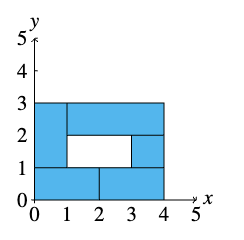

Instance 2:

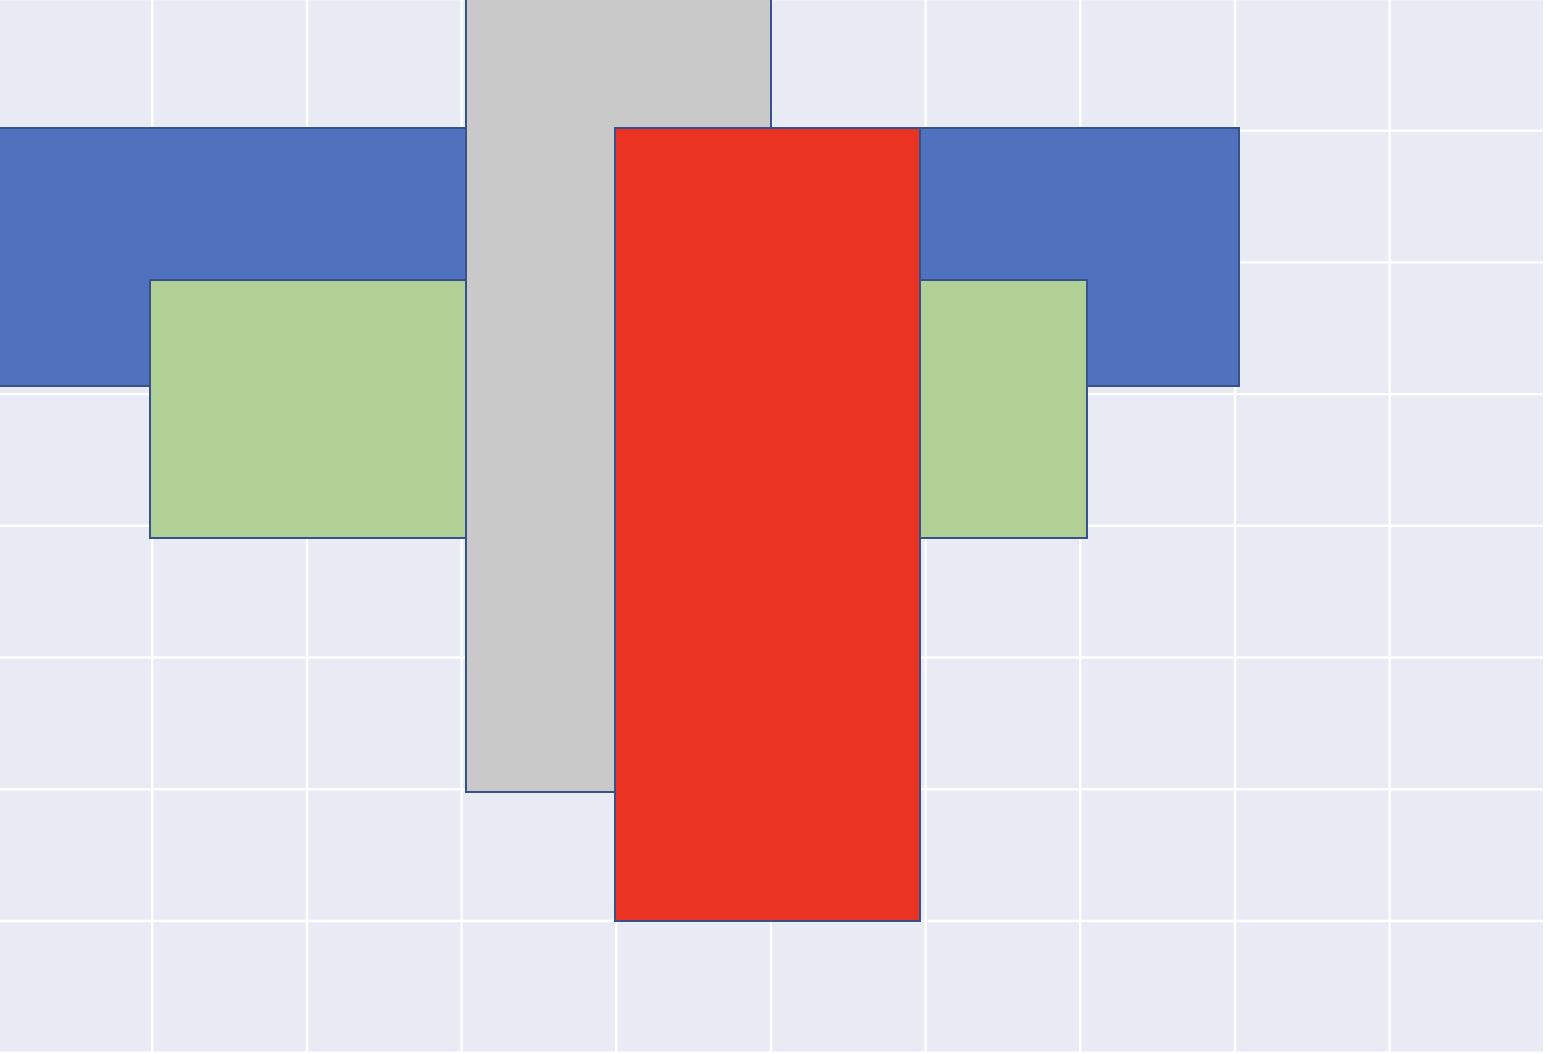

In [ ]:
rect = [
    [(0, 1), (3, 3)],
    [(1, 2), (3, 4)],
    [(3, 0), (5, 6)],
    [(4, 1), (6, 7)],
    [(6, 1), (8, 3)],
    [(6, 2), (7, 4)],
]

rect_count = length(rect)

function interval_overlap(a, b, c, d::Int)
    if a > b 
        a, b = b, a
    end
    if c > d
        c, d = d, c
    end
    return (a < c < b) || (a < d < b) || (c < a < d) || (c < b < d)
end

function rect_intersect(rect1::Vector{Tuple{Int64, Int64}}, rect2::Vector{Tuple{Int64, Int64}})
    x1, y1 = rect1[1]
    x2, y2 = rect1[2]
    x3, y3 = rect2[1]
    x4, y4 = rect2[2]
    return interval_overlap(x1, x2, x3, x4) && interval_overlap(y1, y2, y3, y4)
end

is_rect_overlapped = [[rect_intersect(rect[i], rect[j]) ? 1 : 0 for j in 1:rect_count] for i in 1:rect_count]

function solve_lp_std()
    model = Model(GLPK.Optimizer)
    @variable(model, s[1:rect_count], Bin)
    @objective(model, Max, sum(s[i] for i in 1:rect_count))
    for i in 1:rect_count
        for j in 1:rect_count
            if is_rect_overlapped[i][j] == 1
                @constraint(model, s[i] + s[j] <= 1)
            end
        end
    end
    optimize!(model)
    return [i for i in 1:rect_count if value(s[i]) > 1e-6]
end

std_sol = solve_lp_std()
println("Non-relaxation solution:")
for i in std_sol
    println("Rect ", i, ": ", rect[i])
end

best_val = 0
best_sol = Float64[]

function solve_lp_relaxation(depth::Int=1, fixed_vars::Vector{Float64}=Float64[])
    global best_val, best_sol

    function solve(fixed_vars::Vector{Float64})
        model = Model(GLPK.Optimizer)
        @variable(model, 0 <= s[1:rect_count] <= 1)
        for i in 1:length(fixed_vars)        
            fix(s[i], fixed_vars[i]; force=true)
        end
        @objective(model, Max, sum(s[i] for i in 1:rect_count))
        for i in 1:rect_count
            for j in 1:rect_count
                if is_rect_overlapped[i][j] == 1
                    @constraint(model, s[i] + s[j] <= 1)
                end
            end
        end
        optimize!(model)
        return termination_status(model), objective_value(model), [value(s[i]) for i in 1:rect_count]
    end

    if depth > rect_count
        return
    end

    for val in [0, 1]
        new_fixed_vars = [fixed_vars; val]
        term_stat, obj_val, solution = solve(new_fixed_vars)

        if term_stat != MOI.OPTIMAL
            continue
        end

        all_integers = all(abs(x - round(x)) < 1e-6 for x in solution)

        if all_integers
            if obj_val > best_val
                best_val = obj_val
                best_sol = solution
            end
        end

        solve_lp_relaxation(depth + 1, new_fixed_vars)
    end
end

solve_lp_relaxation()
println("\nRelaxation solution:")
for i in 1:rect_count
    if abs(best_sol[i] - 1.0) < 1e-6
        println("Rect ", i, ": ", rect[i])
    end
end

Non-relaxation solution:
Rect 1: [(0, 1), (3, 3)]
Rect 3: [(3, 0), (5, 6)]
Rect 5: [(6, 1), (8, 3)]

Relaxation solution:
Rect 2: [(1, 2), (3, 4)]
Rect 3: [(3, 0), (5, 6)]
Rect 5: [(6, 1), (8, 3)]


# Question 4: Tie the shoelaces
There are 10 holes in your shoes with 5 holes $A_0, A_1, A_2, A_3$ and $A_4$ on one side and 5 holes $B_0, B_1, B_2, B_3$ and $B_4$ on the other side. You want to find the minimum length of a shoelace that goes through all the holes exactly once and thereby, keeps the shoe tied. You want the shoelace to start from the hole $A_0$ and end at the hole $B_0$ and find an ordering of the vertices in between. One important constraint is that when you start from a hole on the A side, you have to go to a hole on the B side and vice-versa. Of course, it should be a tour, i.e., there should be no cycles smaller than 10.  
Assume that the holes in $A_0, A_1, A_2, A_3, A_4$ have coordinates (0,0), (0,1), (0,2), (0,3), (0,4) and $B_0, B_1, B_2, B_3, B_4$ have coordinates (1,0), (1,1), (1,2), (1,3), (1,4), your task is to find the lacing strategy that minimises the length of the shoe-lace.
Formulate this problem as an ILP and solve it using Julia/JuMP

Min shoelace total length 19.073262114491122
From (0, 0) to (1, 1)
From (0, 1) to (1, 3)
From (0, 2) to (1, 0)
From (0, 3) to (1, 4)
From (0, 4) to (1, 2)
From (0, 0) to (1, 2)
From (0, 1) to (1, 0)
From (0, 2) to (1, 4)
From (0, 3) to (1, 1)
From (0, 4) to (1, 3)


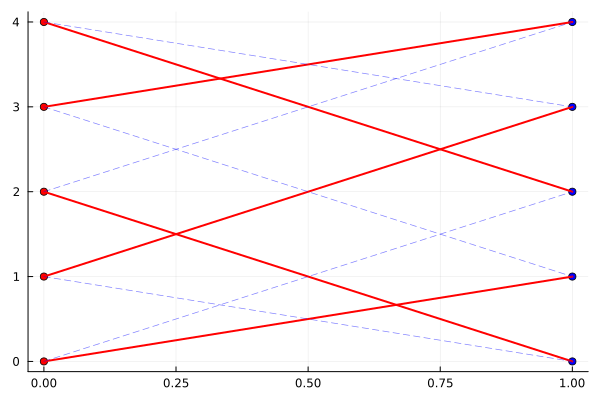

In [74]:
A = [(0,0), (0,1), (0,2), (0,3), (0,4)]
B = [(1,0), (1,1), (1,2), (1,3), (1,4)]
distance = [[hypot(ax - bx, ay - by) for (ax, ay) in A] for (bx, by) in B]
N = length(A)

function solve_lp()
    model = Model(GLPK.Optimizer)
    @variable(model, C[i in 1:N, j in 1:N], Bin)
    @variable(model, D[i in 1:N, j in 1:N], Bin)
    for i in 1:N
        @constraint(model, sum(C[i, j] for j in 1:N) == 1)
        @constraint(model, sum(D[i, j] for j in 1:N) == 1)
    end
    for j in 1:N
        @constraint(model, sum(C[i, j] for i in 1:N) == 1)
        @constraint(model, sum(D[i, j] for i in 1:N) == 1)
    end
    for i in 1:N
        for j in 1:N
            @constraint(model, C[i, j] + D[i, j] <= 1)
        end
    end
    for i in 1:N
        fix(C[i, i], 0; force=true)
        fix(D[i, i], 0; force=true)
    end
    @objective(model, Min, sum((C[i, j] + D[i, j]) * distance[i][j] for i in 1:N for j in 1:N))
    optimize!(model)
    C_edges = [(i, j) for i in 1:N for j in 1:N if value(C[i, j]) == 1]
    D_edges = [(i, j) for i in 1:N for j in 1:N if value(D[i, j]) == 1]
    obj_val = objective_value(model)
    return obj_val, C_edges, D_edges
end

obj_val, C, D = solve_lp()

println("Min shoelace total length ", obj_val)
for (i, j) in C
    println("From (", A[i][1], ", ", A[i][2], ") to (", B[i][1], ", ", B[j][2], ")")
end
for (i, j) in D
    println("From (", A[i][1], ", ", A[i][2], ") to (", B[i][1], ", ", B[j][2], ")")
end

p = plot([x for (x, _) in A], [y for (_, y) in A], seriestype = :scatter, legend = false, color = "red")
plot!(p, [x for (x, _) in B], [y for (_, y) in B], seriestype = :scatter, legend = false, color = "blue")
for (i, j) in C
    plot!(p, [A[i][1], B[j][1]], [A[i][2], B[j][2]], lw=2, color="red")
end
for (i, j) in D
    plot!(p, [A[i][1], B[j][1]], [A[i][2], B[j][2]], lw=0.7, color="blue", alpha=0.5, linestyle=:dash)
end

p

# Question 5: Clustering
Clustering is a fundamental machine learning task used in segmentation, anomaly
detection, and pattern recognition. ILP can be used to determine optimal cluster
assignments by minimising the total intra-cluster distance while satisfying constraints.
For the purpose of this clustering problem, the goal is to find $k=3$ points (called medoids) from among the data points such that the sum of Euclidean distances of all points to their nearest medoid is minimised. Note that unlike the $k$-means problem, the medoid
points can’t be anywhere, but instead have to be one of the data points. Formulate this
problem as an integer linear program. Then, solve it using Julia/JuMP and any solver. Plot
the points together with their closest medoid points.

| X-coordinate | Y-coordinate |
| --- | --- | 
| 55 | 60 | 
| 58 | 55 | 
| 60 | 54 | 
| 64 | 56 | 
| 70 | 65 | 
| 66 | 63 | 
| 71 | 60 | 
| 72 | 50 | 
| 73 | 66 | 
| 76 | 44 | 
| 68 | 43 | 
| 68 | 67 | 
| 75 | 47 | 
| 70 | 42 | 

Minimum total distance to matroid is 52.24988656360193
Medoid points are:
(58, 55)(70, 65)(75, 47)

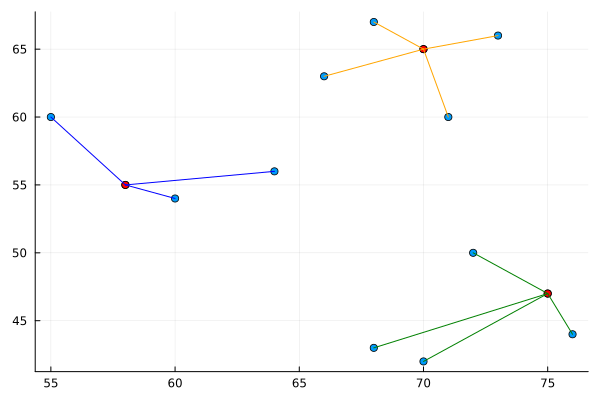

In [ ]:
points = [(55, 60), (58, 55), (60, 54), (64, 56), (70, 65), (66, 63), (71, 60), (72, 50), (73, 66), (76, 44), (68, 43), (68, 67), (75, 47), (70, 42)]

function plot_medoid(point_to_medoid::Vector{Tuple{Int, Int}}, points::Vector{Tuple{Int, Int}}, medoids::Vector{Int})
    colors = [:red, :blue, :green, :purple, :orange, :cyan, :magenta, :yellow, :brown, :pink]
    colorMap = Dict{Int, Symbol}()
    p = plot([x for (x, _) in points], [y for (_, y) in points], seriestype=:scatter, legend=false)
    plot!(p, [points[i][1] for i in medoids], [points[i][2] for i in medoids], seriestype=:scatter, color="red")
    for (i, j) in point_to_medoid
        x1, y1 = points[i]
        x2, y2 = points[j]
        if !in(j, keys(colorMap))
            colorMap[j] = colors[j % length(colors)]
        end
        plot!(p, [x1, x2], [y1, y2], color = colorMap[j])
    end
    return p
end

function solve_lp(points::Vector{Tuple{Int, Int}}, k::Int)
    N = length(points)
    c = [[hypot(x1 - x2, y1 - y2) for (x1, y1) in points] for (x2, y2) in points]
    model = Model(GLPK.Optimizer)
    @variable(model, x[1:N], Bin)
    @variable(model, y[1:N, 1:N], Bin)
    @constraint(model, sum(x[i] for i in 1:N) == k)
    for i in 1:N
        @constraint(model, sum(y[i, j] for j in 1:N) == 1)
    end
    for i in 1:N, j in 1:N
        @constraint(model, y[i, j] <= x[j])
    end
    @objective(model, Min, sum(c[i][j] * y[i, j] for i in 1:N for j in 1:N))
    optimize!(model)
    medoids = [i for i in 1:N if abs(value(x[i]) - 1) < 1e-6]
    obj_val = objective_value(model)
    point_to_medoid = [(i, j) for i in 1:N, j in 1:N if abs(value(y[i, j]) - 1) < 1e-6]
    return point_to_medoid, medoids, obj_val
end

point_to_medoid, medoids, obj_val = solve_lp(points, 3)
println("Minimum total distance to matroid is ", obj_val)
println("Medoid points are:")
for i in medoids
    print("(", points[i][1], ", ", points[i][2], ")")
end

plot_medoid(point_to_medoid, points, medoids)

# Question 6: Scheduling Tasks on Compute Servers
Consider a situation where there are $n$ tasks to be processed on $n$ compute servers. One would like to find an assignment to process all tasks such that exactly one task is processed per server. There is a cost $c_{ij}$ associated with processing the task $i$ on the server $j$ and the goal is to find an assignment of tasks to servers so as to minimise the total cost.

The bipartite graph below describes an instance of this problem. Here, there are 4 tasks
$A_1, A_2, A_3$ and $A_4$, and 4 compute servers $B_1, B_2, B_3$ and $B_4$. The cost $c_{ij}$ associated with processing a task $A_i$ on server $B_j$ is given by the weight of the associated edge. Note that some tasks can’t be processed on certain servers and therefore, the corresponding edges are missing from the graph.

Formulate this problem as an integer linear program. For the instance shown below, solve
the integer linear program using Julia/JuMP. Consider the linear programme obtained by
ignoring the integrality constraints and solve it using Julia/JuMP. What is the ratio
between the optimal ILP and LP solution for the instance below?
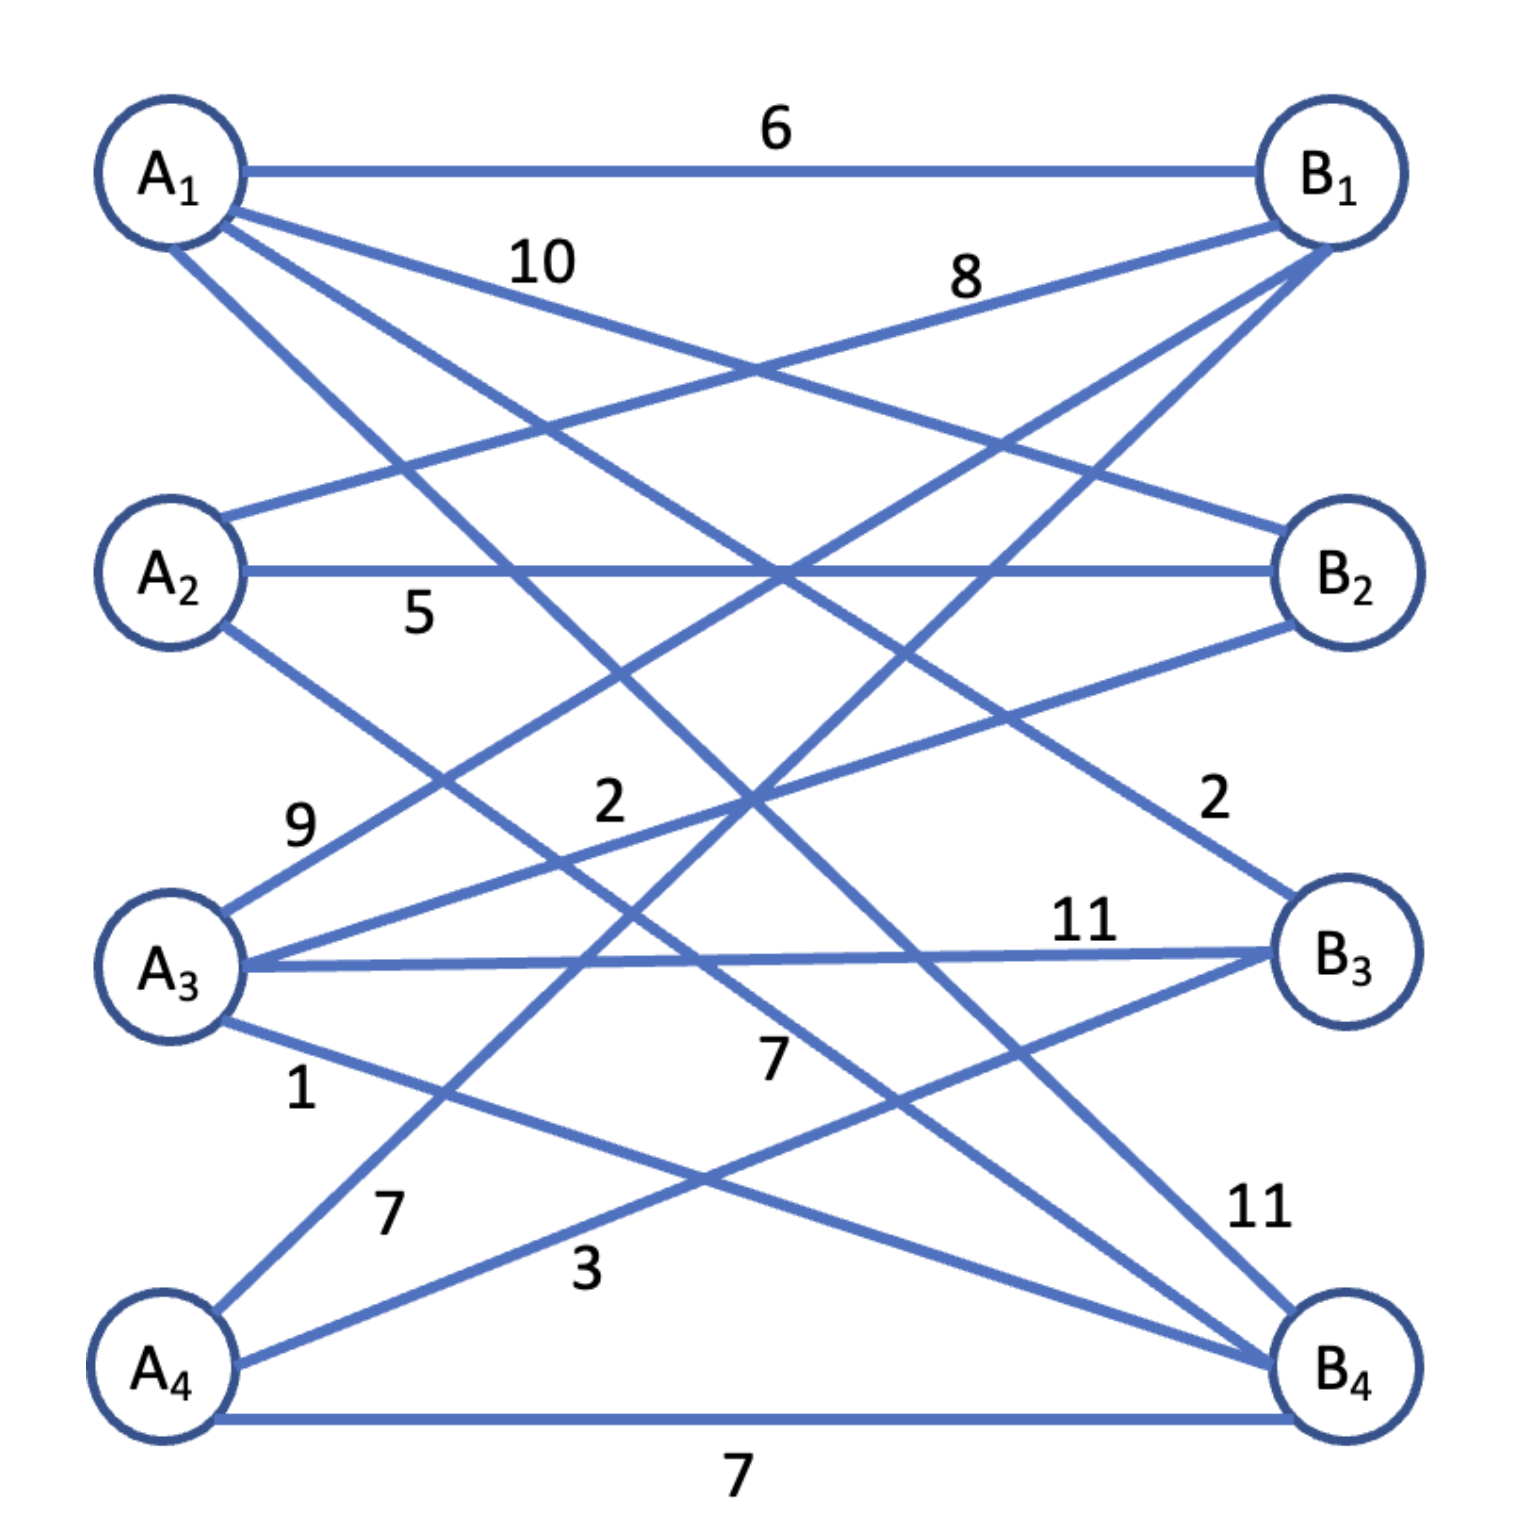

In [45]:
graph = [
    (1, 1, 6),
    (1, 2, 10),
    (1, 3, 2),
    (1, 4, 11),
    (2, 1, 8),
    (2, 2, 5),
    (2, 4, 7),
    (3, 1, 9),
    (3, 2, 2),
    (3, 3, 11),
    (3, 4, 1),
    (4, 1, 7),
    (4, 3, 3),
    (4, 4, 7)
]

M = length(graph)
N = 4

function solve_non_integral_lp(W::Vector{Vector{Int}}, N::Int, M::Int)
    W = [[-1 for _ in 1:N] for _ in 1:N]
    for (u, v, w) in graph
        W[u][v] = w
    end
    model = Model(GLPK.Optimizer)
    @variable(model, 0 <= x[1:N, 1:N] <= 1)
    for u in 1:N, v in 1:N
        if W[u][v] < 0
            W[u][v] = 0     
            fix(x[u, v], 0; force=true)
        end
    end
    for i in 1:N
        @constraint(model, sum(x[i, j] for j in 1:N) == 1)
    end
    for j in 1:N
        @constraint(model, sum(x[i, j] for i in 1:N) == 1)
    end
    @objective(model, Min, sum(W[i][j] * x[i, j] for i in 1:N, j in 1:N))
    optimize!(model)
    obj_val = objective_value(model)
    matched_edges = [(i, j, W[i][j]) for i in 1:N, j in 1:N if abs(value(x[i, j]) - 1.0) < 1e-6]
    return obj_val, matched_edges
end

function solve_integral_lp(W::Vector{Vector{Int}}, N::Int, M::Int)
    W = [[-1 for _ in 1:N] for _ in 1:N]
    for (u, v, w) in graph
        W[u][v] = w
    end
    model = Model(GLPK.Optimizer)
    @variable(model, x[1:N, 1:N], Bin)
    for u in 1:N, v in 1:N
        if W[u][v] < 0
            W[u][v] = 0     
            fix(x[u, v], 0; force=true)
        end
    end
    for i in 1:N
        @constraint(model, sum(x[i, j] for j in 1:N) == 1)
    end
    for j in 1:N
        @constraint(model, sum(x[i, j] for i in 1:N) == 1)
    end
    @objective(model, Min, sum(W[i][j] * x[i, j] for i in 1:N, j in 1:N))
    optimize!(model)
    obj_val = objective_value(model)
    matched_edges = [(i, j, W[i][j]) for i in 1:N, j in 1:N if value(x[i, j]) == 1]
    return obj_val, matched_edges
end

non_int_val, non_int_edges = solve_non_integral_lp(W, N, M)
println("NON-INTEGRAL SOLUTION:")
println("Objective value is ", non_int_val)
for (u, v, w) in non_int_edges
    println("Edge from ", u, " to ", v, " with cost of ", w)
end

println()

int_val, int_edges = solve_integral_lp(W, N, M)
println("INTEGRAL SOLUTION:")
println("Objective value is ", int_val)
for (u, v, w) in int_edges
    println("Edge from ", u, " to ", v, " with cost of ", w)
end

println()
println("The ratio int_solution to non_int_solution = ", int_val / non_int_val)


NON-INTEGRAL SOLUTION:
Objective value is 15.0
Edge from 1 to 1 with cost of 6
Edge from 2 to 2 with cost of 5
Edge from 4 to 3 with cost of 3
Edge from 3 to 4 with cost of 1

INTEGRAL SOLUTION:
Objective value is 15.0
Edge from 1 to 1 with cost of 6
Edge from 2 to 2 with cost of 5
Edge from 4 to 3 with cost of 3
Edge from 3 to 4 with cost of 1

The ratio int_solution to non_int_solution = 1.0
